---
### Cleaned-Up Code

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s, in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [3]:
# DATASET

block_size = 3 # context length: how many characters we take in order to predict the next one
X, Y = [], []
for w in words[:]:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # move the context window one char to the right

X = torch.tensor(X)
Y = torch.tensor(Y)

In [4]:
C = torch.randn((27, 2))
W1 = torch.randn((6, 100))
b1 = torch. randn(100)
W2 = torch.randn((100, 27))
b2 = torch. randn(27)
parameters = [C, W1, b1, W2, b2]

In [5]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [6]:
for p in parameters:
    p.requires_grad = True

In [7]:
print(len(X))

228146


---
### Minibatch training
Instead of doing a forward -> backward iteration on the entire input dataset, we can instead, for each iteration, choose a small batch of sample inputs randomly and do the forward -> backward pass on the small batch. This speeds up training, but, as you might expect, lowers the quality of the gradients leading to worst optimization.

### Finding a Good Learning Rate
We do not want to overshoot the minimas with our gradients. However, we do not want a super small learning rate such that we virtually never converge to the minima. We can identify a good learning rate by experimenting and plotting the results

In [8]:
lre = torch.linspace(-3, 0, 1000) # learning rate exponent
lrs = 10**lre # learning rate samples

In [9]:
# for plotting the learning rate to loss
lri = []
lossi = []

for i in range(1000):
    #minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # (len(X), 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (len(X), 100)
    logits = h @ W2 + b2 # (len(X), 27)
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    eta = lrs[i] # dynamic lr <- we don't need this once we've found a good learning rate
    #eta = 0.1 <- this is approximately the best learning rate according to the graph
    for p in parameters:
        p.data += -eta * p.grad

    # track stats to find appropriate learning rate
    lri.append(eta)
    lossi.append(loss.item())
        
print('loss of current minibatch: ', loss.item())

loss of current minibatch:  6.665921688079834


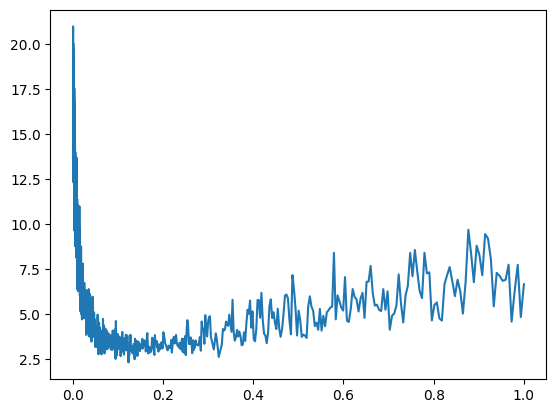

In [10]:
# as we can see, after ~0.2, the learning rate begins overshooting, causing instability in the iterations
plt.plot(lri, lossi)

---
#### Training Code without the learning rate plot
After a good amount of iterations, we may want to decay the learning rate to a smaller number like 0.01 so that that the model may stop overshooting a potentially lower minimum

In [11]:
eta = 0.1

for i in range(1000):
    #minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # (len(X), 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (len(X), 100)
    logits = h @ W2 + b2 # (len(X), 27)
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    for p in parameters:
        p.data += -eta * p.grad
        
print('loss of current minibatch: ', loss.item())

loss of current minibatch:  2.357689142227173


In [12]:
# As we can see here, the loss over the entire dataset is obviously worst than the loss on just the minibatch.
# Minibatch loss and real loss generally follow a trend.
# However lower loss for a specific minibatch is not always indicative of the real loss 
# as it may be that the weights fit better to the specific minibatch, but not to the entire dataset.
full_emb = C[X] # (len(X), 3, 2)
h = torch.tanh(full_emb.view(-1, 6) @ W1 + b1) # (len(X), 100)
full_logits = h @ W2 + b2 # (len(X), 27)
real_loss = F.cross_entropy(full_logits, Y)
print('loss over entire dataset: ', real_loss.item())

loss over entire dataset:  2.5312836170196533


---
### Overfitting
As the number of parameters grow, the NN becomes more capable of overfitting the dataset.
Although we may be able to achieve lower loss with a larger model, a larger model has more parameters that can fit to the training data better. However, this may be undesirable as it may mean that it does not generalize to unseen data. 

It is good practice to split the dataset into three *splits*
1. training split 80%
2. development (dev), or validation split 10%
3. test split 10%

### Training Split
The *training split* is used to train the model. The *dev split* is used to optimize the **hyperparameters** of the NN. For example, the size of the first hidden layer is a hyperparameter. We have it at 100 neurons, but perhaps we can tune the NN with more (or less) nuerons. Likewise, the embed layer maps [27] to $\mathbb{R}^2$, ie: it has 2*block_size neurons, but, again, we may stand to benefit with a larger embed. The *learning rate* is also a hyperparamter, but we've already covered how to tune that.

In [13]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words[:]:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return (X, Y)

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
print(Xtr.shape, Xdev.shape, Xte.shape)

torch.Size([182625, 3]) torch.Size([22655, 3]) torch.Size([22866, 3])


In [14]:
# This time, we are only training with a portion of the dataset.
eta = 0.1
for i in range(1000):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # (len(X), 3, 2)
    h = torch.tanh(emb.view(-1, block_size*2) @ W1 + b1) # (len(X), 100)
    logits = h @ W2 + b2 # (len(X), 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    for p in parameters:
        p.data += -eta * p.grad
        
print('loss of current minibatch: ', loss.item())

loss of current minibatch:  2.639472484588623


In [15]:
# we will first evaluate the loss over the entire training dataset
full_emb = C[Xtr] # (len(X), 3, 2)
h = torch.tanh(full_emb.view(-1, block_size*2) @ W1 + b1) # (len(X), 100)
full_logits = h @ W2 + b2 # (len(X), 27)
real_loss = F.cross_entropy(full_logits, Ytr)
print('loss over testing dataset: ', real_loss.item())

loss over testing dataset:  2.5056419372558594


In [16]:
# this time, we will evaluate the loss of the dev dataset (to see how well it generalizes to unseen data) 
full_emb = C[Xdev] # (len(X), 3, 2)
h = torch.tanh(full_emb.view(-1, block_size*2) @ W1 + b1) # (len(X), 100)
full_logits = h @ W2 + b2 # (len(X), 27)
real_loss = F.cross_entropy(full_logits, Ydev)
print('loss over dev dataset: ', real_loss.item())

loss over dev dataset:  2.499948501586914


### Underfitting
As we can see above, the model performs about the same regardless of whether the data was seen or unseen.
Hence we conclude that the model is not overfitted.
However, since the loss over both datasets are so similar, we are in fact underfitting. That is, we are not using enough parameters for the model to learn the dataset well. 

In [17]:
# the 3->6->100->27 model we used previously was underfitting the data, 
# so we want to modify our hyperparameters to be larger
C = torch.randn((27, 2))
W1 = torch.randn((6, 300))
b1 = torch. randn(300)
W2 = torch.randn((300, 27))
b2 = torch. randn(27)
parameters = [C, W1, b1, W2, b2]

#### More Optimizations
The batch size of the minibatch may be a potential source of bottleneck. 
A small batch size is desirable as it speeds up training, however it results in lower quality graidents.
Sometimes these gradients are insufficient for converging to the desired loss.

Models have multiple different hyperparameters. Tuning the right hyperparameters is part guesswork and part intuition.
eg: we may want to embed the 27 characters in a larger dimension, say $\mathbb{R}^5$.

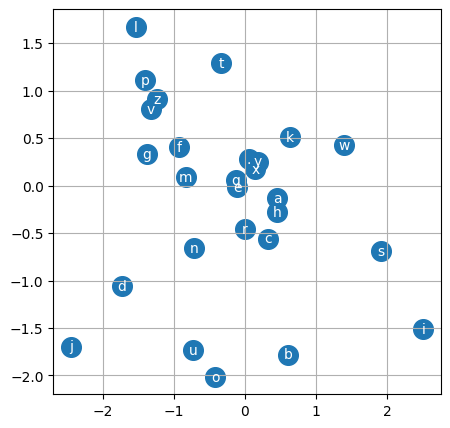

In [18]:
plt.figure(figsize=(5,5))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

Notice that the vowels tend to be clustered together. That means that the model is assigning similar weights to the 
vowels, which is to be expected considering the role vowels play in the english language

---
## Final Code
With some optimizations

In [19]:
# it is good practice to use variables for hyperparameters so that we can easily modify them
embed_dim = 12
C = torch.randn((27, embed_dim))
W1 = torch.randn((embed_dim*block_size, 300))
b1 = torch. randn(300)
W2 = torch.randn((300, 27))
b2 = torch. randn(27)
parameters = [C, W1, b1, W2, b2]
print("number of parameters: ", sum(p.nelement() for p in parameters))

number of parameters:  19551


In [20]:
for p in parameters:
    p.requires_grad = True

In [21]:
# This time, we are only training with a portion of the dataset.
eta = 0.1
for i in range(80000):
    #minibatch of 64 inputs
    ix = torch.randint(0, Xtr.shape[0], (64,))
    
    # forward pass
    emb = C[Xtr[ix]] # (len(X), block_size, embed_dim)
    h = torch.tanh(emb.view(-1, block_size*embed_dim) @ W1 + b1) # (len(X), 100)
    logits = h @ W2 + b2 # (len(X), 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    for p in parameters:
        p.data += -eta * p.grad
    if i > 50000:
        eta = 0.01
        
print('loss of current minibatch: ', loss.item())

loss of current minibatch:  2.3068113327026367


In [22]:
# we will first evaluate the loss over the entire training dataset
full_emb = C[Xtr] # (len(X), block_size, embed_dim)
h = torch.tanh(full_emb.view(-1, block_size*embed_dim) @ W1 + b1) # (len(X), 100)
full_logits = h @ W2 + b2 # (len(X), 27)
real_loss = F.cross_entropy(full_logits, Ytr)
print('loss over testing dataset: ', real_loss.item())

loss over testing dataset:  2.1443207263946533


In [23]:
# this time, we will evaluate the loss of the dev dataset (to see how well it generalizes to unseen data) 
full_emb = C[Xdev] # (len(X), 3, 2)
h = torch.tanh(full_emb.view(-1, block_size*embed_dim) @ W1 + b1) # (len(X), 100)
full_logits = h @ W2 + b2 # (len(X), 27)
real_loss = F.cross_entropy(full_logits, Ydev)
print('loss over dev dataset: ', real_loss.item())

loss over dev dataset:  2.19468092918396


### Sampling

In [24]:
for _ in range(20):
    name = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        name.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in name))

amogie.
kyann.
nanleighoukanson.
kai.
karyllondia.
ley.
ray.
stra.
avahna.
tra.
javem.
tis.
sarioleu.
cagan.
melaydy.
kaylynn.
malin.
farie.
cec.
era.
